# Gaussian Mixtures - Clustering and Anomaly Detection

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

## Get the data

We generate sample data drawn from three two-dimensional Gaussian distributions with different means and covariance matrices.

In [2]:
weights = [1, 2, 2]
means = np.array([
    [3.4, 1.0],
    [-1.4, 1.4],
    [0.0, 0.0],
])
cov = np.array([
    [[1.1, -0.03],
    [-0.03, 0.95]],
    [[0.6, 0.7],
    [0.7, 1.2]],
    [[0.7, 0.8],
    [0.8, 1.2]]
])
X = None
for i in range(len(means)):
    if X is None:
        X = np.random.multivariate_normal(means[i], cov[i], size=weights[i]*300)
    else:
        X = np.concatenate((X, np.random.multivariate_normal(means[i], cov[i], size=weights[i]*300)))

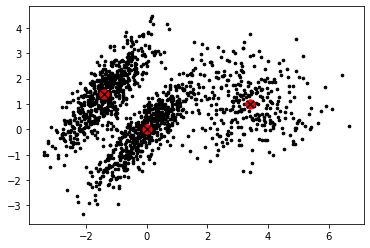

In [3]:
plt.scatter(X[:, 0], X[:, 1], s=7, c='k')
plt.scatter(means[:, 0], means[:, 1], s=86, c='r', marker='o')
plt.scatter(means[:, 0], means[:, 1], s=56, c='k', marker='x')
plt.show()

## Train the model

In [4]:
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

Show the fitted parameters:

In [5]:
gm.weights_

array([0.39128057, 0.40003223, 0.20868721])

In [6]:
gm.means_

array([[-0.05715574, -0.07903563],
       [-1.37697363,  1.4304211 ],
       [ 3.3122997 ,  1.01854317]])

In [7]:
gm.covariances_

array([[[ 0.67312988,  0.75692917],
        [ 0.75692917,  1.13047057]],

       [[ 0.56228233,  0.64343662],
        [ 0.64343662,  1.11624073]],

       [[ 1.21000881, -0.05757368],
        [-0.05757368,  1.09319432]]])

## Make predictions

In [8]:
gm.predict(X)

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

In [9]:
gm.predict_proba(X)

array([[3.57519212e-29, 3.14059979e-55, 1.00000000e+00],
       [1.32824474e-12, 7.86871063e-33, 1.00000000e+00],
       [7.33962434e-14, 4.03138304e-34, 1.00000000e+00],
       ...,
       [9.98449340e-01, 2.91364798e-07, 1.55036846e-03],
       [9.99520622e-01, 5.12328653e-05, 4.28144810e-04],
       [9.94862398e-01, 6.33102661e-07, 5.13696860e-03]])

## Sample new instances

Since Gaussian mixture models are generative models, we can easily create new samples from the fitted model:

In [10]:
gm.sample(5)

(array([[-0.6244226 , -0.51420686],
        [-2.60639239,  0.7336356 ],
        [-1.67677167,  1.17047313],
        [ 3.96406556,  1.73515139],
        [ 3.42361078,  2.56367882]]),
 array([0, 1, 1, 2, 2]))

## Probability densities

The Gaussian mixture model provides the probability density for each instance or new point. Integrating over a small region around this point would yield the probability for an instance to fall into this region. Actually, the model returns the **log** of the probability densities:

In [11]:
gm.score_samples(X)

array([-4.86347463, -3.67075781, -4.52812403, ..., -1.98988995,
       -2.2521129 , -2.07611564])

The actual probability densities are given by the exponential of the scores:

In [12]:
np.exp(gm.score_samples(X))

array([0.0077236 , 0.02545717, 0.01080092, ..., 0.13671047, 0.10517676,
       0.12541643])

## Plot the decision boundaries

In [15]:
resolution = 0.01
x1_min = min(X[:, 0])-0.2
x1_max = max(X[:, 0])+0.2
x2_min = min(X[:, 1])-0.2
x2_max = max(X[:, 1])+0.2
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

# Probability density values
ZZ = gm.score_samples(np.array([xx1.ravel(), xx2.ravel()]).T)
ZZ = ZZ.reshape(xx1.shape)

# Cluster predictions
Z = gm.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = Z.reshape(xx1.shape)

<Figure size 432x288 with 0 Axes>

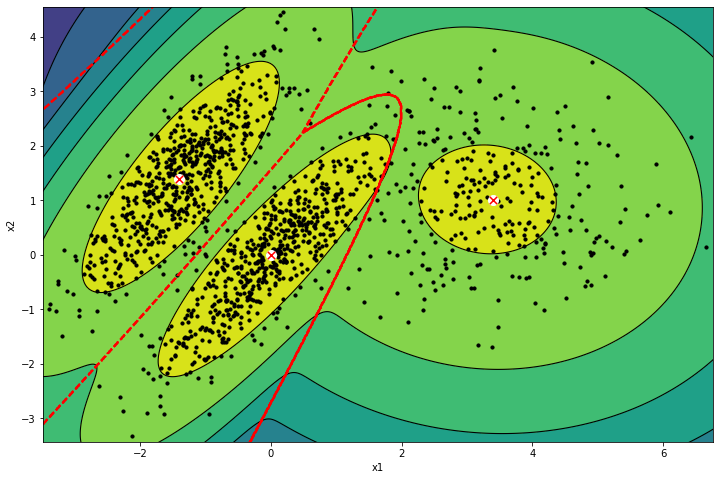

In [16]:
plt.clf()
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, ZZ)
plt.contour(xx1, xx2, ZZ, linewidths=1.1, colors='k', linestyles='solid')
plt.scatter(X[:, 0], X[:, 1], s=10, c='k')
plt.scatter(means[:, 0], means[:, 1], s=100, c='w', marker='o')
plt.scatter(means[:, 0], means[:, 1], s=56, c='r', marker='x')
plt.contour(xx1, xx2, Z, linewidths=1.9, colors='r', linestyles='dashed')
plt.xlim(x1_min+0.1, x1_max-0.1)
plt.ylim(x2_min+0.1, x2_max-0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Black points in the plot correspond to the data. The centroids of the three two-dimensional Gaussian distributions is denoted by red crosses on white circles. The decision boundaries of the three clusters fitted by the Gaussian mixture model are shown as red dashed lines. The colored areas indicate the contours of the probability density of the fitted model.

## Anomaly detection

Gaussian mixture models can be easily used for anomaly detection. Let's impose an anomaly treshold `anomaly_threshold` of x%. All instances falling below the x% percentile threshold are hence identified as outliers (or anomalies).

In [19]:
anomaly_threshold = 4
log_densities = gm.score_samples(X)
density_threshold = np.percentile(log_densities, anomaly_threshold)
anomalies = X[log_densities < density_threshold]

<Figure size 432x288 with 0 Axes>

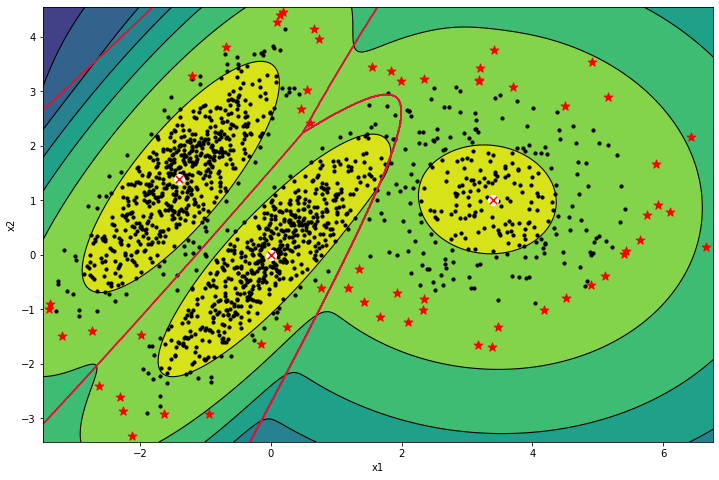

In [34]:
plt.clf()
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, ZZ)
plt.contour(xx1, xx2, ZZ, linewidths=1.1, colors='k', linestyles='solid')
plt.scatter(X[:, 0], X[:, 1], s=10, c='k')
plt.scatter(anomalies[:, 0], anomalies[:, 1], s=84, c='r', marker='*')
plt.scatter(means[:, 0], means[:, 1], s=100, c='w', marker='o')
plt.scatter(means[:, 0], means[:, 1], s=56, c='r', marker='x')
plt.contour(xx1, xx2, Z, linewidths=1.2, colors='crimson', linestyles='solid')
plt.xlim(x1_min+0.1, x1_max-0.1)
plt.ylim(x2_min+0.1, x2_max-0.1)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In this plot, instances that are considered anomalies are shown with red star markers.

## Manually finding the best number of clusters

In order to find the best number of clusters in Gaussian mixture models, we try to maximize the likelihood function. In sklearn, we have to useful metrics that are implemented as measures of the likelihood: the *Bayesian information criterion* (BIC) and the *Akaike information criterion* (AIC). The best model typically minimizes both of these metrics.

In [37]:
bic_scores = []
aic_scores = []
for i in range(1, 10):
    gm = GaussianMixture(n_components=i, n_init=10)
    gm.fit(X)
    bic_scores.append(gm.bic(X))
    aic_scores.append(gm.aic(X))

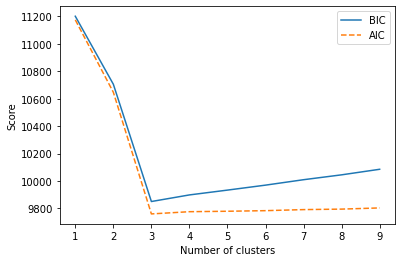

In [43]:
plt.clf()
plt.plot(range(1,10), bic_scores, label='BIC')
plt.plot(range(1,10), aic_scores, label='AIC', linestyle='dashed')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

The minimum of both scores is indeed found at 3, which was expected since the data was generated from three two-dimensional Gaussian distributions.

## Automatically finding the best number of clusters: *Bayesian Gaussian Mixture Models*

We can also let sklearn find the optimal number of clusters by setting `n_components` to a **higher** value than the number of clusters that we would expect to be relevant (this requires some *a prioi* knowledge or some educated guess about the model, of course). Sklearn will then apply small or vanishing weights to irrelevant clusters.

In [47]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, max_iter=10000)
bgm.fit(X)
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

As can be seen, the BGM model automatically applies a vanishing weight to all clusters but the first three, indicating that `n_components=3` suffices to cluster the data sufficiently.